<a id="section__top"></a>

# Project  3 - Subreddit Classifier
## Modeling and Conclusion
General Assembly DSI CC7 Project 3
<br>Anne Kerr - SF<br>
Due April 5, 2019


This notebook contains the following sections:

-  [Loading and Preparing the Data](#section__Load_and_Prep)
-  [Model Search](#section__Model_Search)
-  [Final Model Tuning](#section__Model_Tuning)
-  [Predictions and Evaluation](#section__Predictions)
-  [Conclusion](#section__Conclusion)


In [1]:
from sklearn.pipeline import Pipeline
#Importing NumPy and Pandas.
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler   #transformers

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats

# Import Tokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pactools.grid_search import GridSearchCVProgressBar
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
from wordcloud import WordCloud, STOPWORDS 
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

<a id="section__Load_and_Prep"></a>


#### Read and Pre-process the Data
We begin by reading the cleaned final dataset into a single dataframe. 

  
Note: We already deleted duplicates and have no missing values for the selftext (from which we will derive the features for our model) or the subreddit name, our target.

[back to top](#section__top)

In [3]:
df = pd.read_csv('../data/cleaned_posts_all.csv')

df.head()

,subreddit,id,cleaned,author,created,ups,downs
0,travel,b6i1po,hey travellers in this weekly community discus...,AutoModerator,1.553775e+09,10,0
1,travel,b7owfp,hi reddit my friends and i will be going on ou...,elysxan,1.554046e+09,5,0
2,travel,b7ou42,had a free weekend looking for a day of hiking...,logflumepirate,1.554046e+09,4,0
3,travel,b7q4dz,hi all a friend and i are heading to nepal fro...,jyeatbvg,1.554053e+09,2,0
4,travel,b7pzbp,does anyone have any tips on ride sharing from...,ruffianrevolution,1.554052e+09,2,0


###### Define the target class
Due to eliminating duplicates and posts with no actual text we were left with fewer than hoped for in each class. If we make travel the positive class, and all others the negative class. We will have a more balanced dataset. 

In [4]:
df['target'] = df['subreddit'].map(lambda x: 1 if x == 'travel' else 0)

y = df['target']

We can see below that the dataset isn't perfectly balanced, but it isn't bad. Hopefully there will be enough data to create and test some good models.

In [5]:
y.value_counts()

0    1039
1     808
Name: target, dtype: int64

Text(0.5, 1.0, 'Travel vs (Fitness, Wine, and Gardening)')

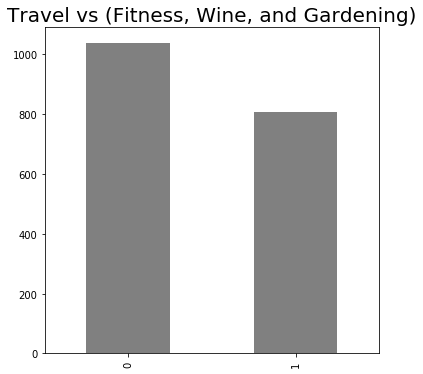

In [6]:
plt.figure(figsize=(6,6))
df['target'].value_counts().plot(kind='bar', color=['gray'])

plt.title('Travel vs (Fitness, Wine, and Gardening)', fontsize=20)

###### Baseline Accuracy
By simply predicting the majority class accuracy would be 56.3%

In [7]:
y.value_counts(normalize=True)

0    0.562534
1    0.437466
Name: target, dtype: float64

###### Model Prep
Next we set set up X and perform train_test_split so we have a dataset for training the models and one on which to test. We use random_state=42 as a seed to ensure the results can be reproduce. We stratify on y to ensure that we have a balance of our targt varable in both the training and the test data. This is particularly important if the data is unbalanced with respect to y, but in general a good idea.


In [8]:
X = df['cleaned']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=42,
                                                   stratify=y) 

In [9]:
print(f'Total posts: {df.shape[0]}, Training data: {X_train.shape[0]}, Test data: {X_test.shape[0]}')

Total posts: 1847, Training data: 1385, Test data: 462


<a id='section__Model_Search'></a>

#### Model Approach

For this project we will construct several pipelines use GridSearchCV to test various models and parameter combinations, searching for the best predictive model.

I chose five different combinations. Each was constructed with a pipeline that consisted of a tokenizer (either CountVectorizer or Tfidif) and an estimator. I tried Logistic Regression Naive Bayes, KNN, Random Forest, and AdaBoost. The table below summarizes the reslts. The params columns listed the different best parameters as selected by the GridSearchCV. 

The best scores were models that chose 1500 as max features. I assume that if I let it select even more features the scores would get even better, but while these models may be good for Kaggle competitions, they do not seem particularly useful for predicting whether or not new posts are in the r/travel thread. For this reason I decided to look for the model that seemed to perform the best on smaller feature sets. 

From this information it looks like the best option is Naive Bayes with Tfidf, and the second best is LogisticRegression with CountVectorizer. I did not try Tfidif with Logistic Regression, or CountVectorizer with Naive Bayes. I will try these variations before deciding on a final model.

*Note:* The model search performance is listed in two tables here. The first is simplified for the presentation, the second was useful to keep track of the parameter options that were chosen as best in each of the different models. I included only the differences.

The pipelines and gridsearch for each combo appear after the tables.

[back to top](#section__top)

|attempt                            |train score|test score|difference|
|-----------------------------------|------------|---------|----------|
|CountVectorizer/Logistic Regression|.889       |.870      |.019      |
|                                   |.896       |.885      |.011      |
|Tfidif/Naive Bayes                 |.974       |.967      |.007      |   
|                                   |.870       |.865      |.005      |
|Tfidif/KNN                         |.836       |.807      |.029      |        
|Tfidif/Random Forest               |.984       |.883      |.101      |
|                                   |.957       |.831      |.126      |
|Tfidif/AdaBoost                    |.981       |.883      |.098      |




<a id="section__scores_grid"></a>

| Model  |  Params  |  Training/Test Scores    |
| ------ | -------- | ----------------| ---------------|
|[Logistic Regression with CountVectorizer](#section__lr) | 'cvec__max_features': 1500, 'cvec__min_df': 5  |Train Score GS1A: 0.9992779783393502|
|  |     |Test Score GS1A: 0.9588744588744589|
|  |     |-----------------------------------|
|  | 'cvec__max_features': 50, 'cvec__min_df': 2 |Train Score GS1B: 0.8967509025270758
|  |  |Test Score GS1B: 0.8852813852813853|
|  |     |-----------------------------------|
|[Naive Bayes with Tfidf](#section__nbayes) |'tfidf__max_df': 0.9, 'tfidf__max_features': 1500, |Train Score GS2A: 0.9740072202166065|
|  |  |Test Score GS2A: 0.9675324675324676|
|  |     |-----------------------------------|
|  |'tfidf__max_df': 0.75, 'tfidf__max_features': 50|Train Score GS2B: 0.8700361010830325|
|  |  |Test Score BS2B: 0.8658008658008658|
|  |     |-----------------------------------|
|[KNN with Tfidf](#section__knn)  |'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3|Train Score GS3A: 0.836101083032491|
|  |  |Test Score GS3A: 0.8073593073593074|
|  |     |-----------------------------------|
|  |(Same)|Train Score GS3B: 0.836101083032491|
|  |  |Test Score GS3B: 0.8073593073593074|
|  |     |-----------------------------------|
|[Random Forestm with Tfidf](#section__random_forest)   | 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 50, 'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 2 |Train Score GS4A: 0.9848375451263538|
|  |  |Test Score GS4A: 0.8831168831168831|
|  |     |-----------------------------------|
|  |'rf__max_depth': 5, 'rf__max_features': 50, 'rf__n_estimators': 10, 'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3  |Train Score GS4B: 0.8570397111913357|
|  |  |Test Score GS4B: 0.8311688311688312|
|  |     |-----------------------------------|
|[ADA with Tfidif](#section__ada)  | 'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3 |Train Score GS5A: 0.9010830324909748|
|  |  |Test Score GS5A: 0.8831168831168831|
|  |     |-----------------------------------|
|  | (same) |Train Score GS5B: 0.9010830324909748
|  |  |Test Score GS5B: 0.8831168831168831|
|  |     |-----------------------------------|





<a id="section__lr"></a>
#### Logistic Regression with CountVectorizer

[back](#section__scores_grid)

In [10]:
#Logistic regression with count vectorizer
pipe = Pipeline([
    ('cvec', CountVectorizer()),   #count vectorizor
    ('lr', LogisticRegression())     #model 
])

In [11]:
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [50, 100, 500, 1000, 1500],      #iterate over these options to see what is best
    'cvec__min_df': [2,3,5],
    'cvec__max_df': [.75, .8, .9, .95],
    'lr__random_state': [42]
    ##### note you could add 'cvec_tokenizer' : [None, custom_tokenizer]
}
gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train) # Also does cv in the background
print(f'gs.best.score_: {gs.best_score_}') # cross_val_score
print(f'gs.best.params_: {gs.best_params_}')
gs.best_estimator_

gs.best.score_: 0.9494584837545126
gs.best.params_: {'cvec__max_df': 0.75, 'cvec__max_features': 1500, 'cvec__min_df': 5, 'cvec__stop_words': 'english', 'lr__random_state': 42}


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=1500, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
       ..., penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [12]:
print(f'Train Score GS1A: {gs.score(X_train,y_train)}')
print(f'Test Score GS1A: {gs.score(X_test,y_test)}')

Train Score GS1A: 0.9992779783393502
Test Score GS1A: 0.9588744588744589


In [13]:
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [10, 25, 50],      #iterate over these options to see what is best
    'cvec__min_df': [2,3,5],
    'cvec__max_df': [.75, .8, .9, .95],
    'lr__random_state': [42]
}

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train) # Also does cv in the background

print(f'gs.best.score_: {gs.best_score_}') # cross_val_score
print(f'gs.best.params_: {gs.best_params_}')
gs.best_estimator_

gs.best.score_: 0.8801444043321299
gs.best.params_: {'cvec__max_df': 0.75, 'cvec__max_features': 50, 'cvec__min_df': 2, 'cvec__stop_words': 'english', 'lr__random_state': 42}


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s..., penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [14]:
print(f'Train Score GS1B: {gs.score(X_train,y_train)}')
print(f'Test Score GS1B: {gs.score(X_test,y_test)}')

Train Score GS1B: 0.8967509025270758
Test Score GS1B: 0.8852813852813853


<a id="section__nbayes"></a>
#### Naive Bayes with Tfidf
[back](#section__scores_grid)

In [15]:
#Naive Bayes with Tfidf
pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('mnb', MultinomialNB())        #model 
])

In [16]:
params2 = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__max_features': [1000, 1500],      #iterate over these options to see what is best
        'tfidf__min_df': [2,3],
        'tfidf__max_df': [.9, .95]
}

gs2 = GridSearchCV(pipe2, param_grid=params2, cv=3)
gs2.fit(X_train, y_train) # Also does cv in the background

print(f'gs2.best.score_: {gs2.best_score_}') # cross_val_score
print(f'gs2.best.params_: {gs2.best_params_}')
gs2.best_estimator_

gs2.best.score_: 0.9566787003610109
gs2.best.params_: {'tfidf__max_df': 0.9, 'tfidf__max_features': 1500, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1500, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [17]:
print(f'Train Score GS2A: {gs2.score(X_train,y_train)}')
print(f'Test Score GS2A: {gs2.score(X_test,y_test)}')

Train Score GS2A: 0.9740072202166065
Test Score GS2A: 0.9675324675324676


In [18]:
params2 = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
        'tfidf__min_df': [2, 3, 5],
        'tfidf__max_df': [.75, .8, .9, .95]
}
gs2 = GridSearchCV(pipe2, param_grid=params2, cv=3)
gs2.fit(X_train, y_train) # Also does cv in the background
print(f'gs2.best.score_: {gs2.best_score_}') # cross_val_score
print(f'gs2.best.params_: {gs2.best_params_}')
gs2.best_estimator_

gs2.best.score_: 0.8584837545126354
gs2.best.params_: {'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [19]:
print(f'Train Score GS2b: {gs2.score(X_train,y_train)}')
print(f'Test Score BS2b: {gs2.score(X_test,y_test)}')

Train Score GS2b: 0.8700361010830325
Test Score BS2b: 0.8658008658008658


<a id="section__knn"></a>
#### KNN with Tfidf
[back](#section__scores_grid)

In [20]:
#KNN with Tfidf
pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('knn', KNeighborsClassifier(n_neighbors=20))        #model 
])

In [21]:
params3 = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
        'tfidf__min_df': [2, 3, 5],
        'tfidf__max_df': [.75, .8, .9, .95]
}
gs3 = GridSearchCV(pipe3, param_grid=params3, cv=3)
gs3.fit(X_train, y_train) # Also does cv in the background

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...i',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidf__stop_words': [None, 'english'], 'tfidf__max_features': [10, 25, 50], 'tfidf__min_df': [2, 3, 5], 'tfidf__max_df': [0.75, 0.8, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print(f'gs3.best.score_: {gs3.best_score_}') # cross_val_score
print(f'gs3.best.params_: {gs3.best_params_}')
gs3.best_estimator_

gs3.best.score_: 0.779783393501805
gs3.best.params_: {'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...i',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform'))])

In [23]:
print(f'Train Score GS3A: {gs3.score(X_train,y_train)}')
print(f'Test Score GS3A: {gs3.score(X_test,y_test)}')

Train Score GS3A: 0.836101083032491
Test Score GS3A: 0.8073593073593074


In [24]:
params3 = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
        'tfidf__min_df': [2, 3, 5],
        'tfidf__max_df': [.75, .8, .9]
}
gs3 = GridSearchCV(pipe3, param_grid=params3, cv=3)
gs3.fit(X_train, y_train) # Also does cv in the background
print(f'gs3.best.score_: {gs3.best_score_}') # cross_val_score
print(f'gs3.best.params_: {gs3.best_params_}')
gs3.best_estimator_

gs3.best.score_: 0.779783393501805
gs3.best.params_: {'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...i',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform'))])

In [25]:
print(f'Train Score GS3B: {gs3.score(X_train,y_train)}')
print(f'Test Score GS3B: {gs3.score(X_test,y_test)}')

Train Score GS3B: 0.836101083032491
Test Score GS3B: 0.8073593073593074


<a id="section__random_forest"></a>
#### Random Forestm with Tfidf
[back](#section__scores_grid)

In [26]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [27]:
#KNN with Tfidf
pipe4 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('rf', RandomForestClassifier(random_state=42))        #model 
])

In [28]:
params4 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [.75, .8, .9, .95],
    'rf__n_estimators': [10, 50, 100],  #to get rid of waranigs
    'rf__max_depth': [None, 3, 5],
    'rf__max_features': ['auto']  #auto is default
   }   
gs4 = GridSearchCV(pipe4, param_grid=params4, cv=5)
gs4.fit(X_train, y_train) # Also does cv in the background
print(f'gs4.best.score_: {gs4.best_score_}') # cross_val_score
print(f'gs4.best.params_: {gs4.best_params_}')
gs4.best_estimator_

gs4.best.score_: 0.8606498194945849
gs4.best.params_: {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 50, 'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 2, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...mators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [29]:
print(f'Train Score GS4A: {gs4.score(X_train,y_train)}')
print(f'Test Score GS4A: {gs4.score(X_test,y_test)}')

Train Score GS4A: 0.9848375451263538
Test Score GS4A: 0.8831168831168831


In [30]:
params4 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [50],      #iterate over these options to see what is best
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [.75, .8, .9, .95],
    'rf__n_estimators': [10],  #to get rid of waranigs
    'rf__max_depth': [3, 5],
    'rf__max_features': [50]  #auto is default
   }   
gs4 = GridSearchCV(pipe4, param_grid=params4, cv=5)
gs4.fit(X_train, y_train)
print(f'gs4.best.score_: {gs4.best_score_}') # cross_val_score
print(f'gs4.best.params_: {gs4.best_params_}')
gs4.best_estimator_

gs4.best.score_: 0.8418772563176895
gs4.best.params_: {'rf__max_depth': 5, 'rf__max_features': 50, 'rf__n_estimators': 10, 'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...mators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [31]:
print(f'Train Score GS4B: {gs4.score(X_train,y_train)}')
print(f'Test Score GS4B: {gs4.score(X_test,y_test)}')

Train Score GS4B: 0.8570397111913357
Test Score GS4B: 0.8311688311688312


<a id="section__ada"></a>

#### ADA with Tfidif

[back](#section__scores_grid)

In [32]:
# Tuning AdaBoostClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [33]:
#AdaBoost with Tfidf
pipe5 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('ada', AdaBoostClassifier())        #model 
])

In [34]:
params5 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [.75, .8, .9, .95]
    #'ada__n_estimators': [60,70,80],
    #'ada__base_estimator__max_depth':[1,2],
    #'ada__base_estimator__max_features':[None,10]    
}
gs5 = GridSearchCV(pipe5, param_grid=params5, cv=5)
gs5.fit(X_train, y_train)

print(f'gs5.best.score_: {gs5.best_score_}') # cross_val_score
print(f'gs5.best.params_: {gs5.best_params_}')
gs5.best_estimator_

gs5.best.score_: 0.8483754512635379
gs5.best.params_: {'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [35]:
print(f'Train Score GS5A: {gs5.score(X_train,y_train)}')
print(f'Test Score GS5A: {gs5.score(X_test,y_test)}')

Train Score GS5A: 0.9010830324909748
Test Score GS5A: 0.8831168831168831


In [36]:
params5 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [.75, .8, .9, .95]
    #'ada__n_estimators': [60,70,80],
    #'ada__base_estimator__max_depth':[1,2],
    #'ada__base_estimator__max_features':[50]    
}
gs5 = GridSearchCV(pipe5, param_grid=params5, cv=5)
gs5.fit(X_train, y_train)

print(f'gs5.best.score_: {gs5.best_score_}') # cross_val_score
print(f'gs5.best.params_: {gs5.best_params_}')
gs5.best_estimator_

gs5.best.score_: 0.8483754512635379
gs5.best.params_: {'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [37]:
print(f'Train Score GS5B: {gs5.score(X_train,y_train)}')
print(f'Test Score GS5B: {gs5.score(X_test,y_test)}')

Train Score GS5B: 0.9010830324909748
Test Score GS5B: 0.8831168831168831


<a id='section__Model_Tuning'></a>

####  Additional Tuning before deciding

Having run through a variety of scenrios using the above, I determined that my best results were with Logistic Regression and Naive Bayes. I had not tried Naive Bayes with CountVectorize or LogisticRegression with Tfidif, so I decided to try these combinations, and test even more parameters to fine the best before deciding on a final model. It at first seemed GridSearch would always pick the max features I allow, and the min_df I allow. Through more experimentation I was able to find a combination that produced the best score, with parameters that fell in the middle of the ranges for which I tried, using Logistic Regression with Tfidif.  

[back to top](#section__top)

In [38]:
#Naive Bayes with CountVectorizer
pipeNB = Pipeline([
    ('cvec', CountVectorizer()),   #count vectorizor
    ('mnb', MultinomialNB())        #model 
])
paramsNB = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [1000, 1500],     
    'cvec__min_df': [2, 2, 3],
    'cvec__max_df': [.10, .25, .50, .75, .9]
}
gsNB = GridSearchCV(pipeNB, param_grid=paramsNB, cv=3)
gsNB.fit(X_train, y_train) # Also does cv in the background

print(f'NB best score_: {gsNB.best_score_}') # cross_val_score
print(f'NB best params_: {gsNB.best_params_}')
print(f'NB best estimator: {gsNB.best_estimator_}')
nb_train_score = gsNB.score(X_train,y_train)
nb_test_score = gsNB.score(X_test,y_test)
nb_score_diff = gsNB.score(X_train,y_train) - gsNB.score(X_test,y_test)
print(f'NB Train Score: {nb_train_score}')
print(f'NB Test Score: {nb_test_score}')
print(f'NB Train - Test Score: = {nb_score_diff}')



NB best score_: 0.9588447653429603
NB best params_: {'cvec__max_df': 0.5, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__stop_words': 'english'}
NB best estimator: Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=1500, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
NB Train Score: 0.9718411552346571
NB Test Score: 0.9588744588744589
NB Train - Test Score: = 0.012966696360198204


In [39]:
## Logistic regression with Tfidif
pipeLR = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor 
    ('lr', LogisticRegression())     #model 
])
paramsLR = {
    'lr__random_state': [42],
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [30, 50, 100, 500, 1500, 2000, 2500, 3000],      #iterate over these options to see what is best
    'tfidf__min_df': [1, 2, 3, 5],
    'tfidf__max_df': [ .10, .25, .50, .75, .9]

}
gsLR = GridSearchCV(pipeLR, param_grid=paramsLR, cv=3)
gsLR.fit(X_train, y_train) # Also does cv in the background
print(f'LR best score_: {gsLR.best_score_}') # cross_val_score
print(f'LR best params_: {gsLR.best_params_}')
#print(f'LR best estimator: {gsLR.best_estimator_}')
lr_train_score = gsLR.score(X_train,y_train)
lr_test_score = gsLR.score(X_test,y_test)
lr_score_diff = gsLR.score(X_train,y_train) - gsLR.score(X_test,y_test)
print(f'LR Train Score: {lr_train_score}')
print(f'LR Test Score: {lr_test_score}')
print(f'LR Train - Test Score: = {lr_score_diff}')

predictions = gsLR.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
print(f'Accuracy rate: {accuracy}, misclassification rate: {misclassification}')

LR best score_: 0.9501805054151624
LR best params_: {'lr__random_state': 42, 'tfidf__max_df': 0.25, 'tfidf__max_features': 2500, 'tfidf__min_df': 1, 'tfidf__stop_words': 'english'}
LR Train Score: 0.9855595667870036
LR Test Score: 0.9588744588744589
LR Train - Test Score: = 0.026685107912544748
Accuracy rate: 0.9588744588744589, misclassification rate: 0.04112554112554112


##### Final tuning of the chosen model
Iterating over different parameter sets, looking for: 
-  Maximum scores
-  Minimum difference between train and test score
-  Maximum Accuracy of Predictions (Looking for 90%)
-  All other things being equal, simplicity of model
<br>


Here is a snapshot of the different parameters that were tested. Following is a table that summarizes the results.

```
#Logistic regression with Tfidif
pipeLR = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor 
    ('lr', LogisticRegression())     #model 
])
paramsLR = {
    'lr__random_state': [42],
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [30, 50, 100, 500, 1500, 2000, 2500, 3000],      #iterate over these options to see what is best
    'tfidf__min_df': [ 1, 2, 3, 5],
    'tfidf__max_df': [ .10, .25, .50, .75, .9]

}
```

|max_features|min_df|max_df|train score|test score|score diff|accuracy|notes|
|------------|------|------|-----------|----------|----------|--------|-----|
|50|1|.25|.889|.870|.0194|.870|
|100|2|.5|.921|.900|.02|.90|
|500|5|.5|.973|.961|.012|.961|This is the winner|
|1500|2|.5|.984|.961|.023|.961|
|2000|1|.25|.985|.958|.026|.958|
|2500|1|.25|.985|.958|.026|.958|Hit max features, would not grow beyond|
| 2000|   3 | .25 | .985 | .958|.026  | .958 | Constrained min_df to 3|

*Note:* To improve on this workflow for the future, build a function to iterate through these options, and put the results metrics of interest in a dataframe.

Moving forward with the chosen model and the chosen best parameters:

In [40]:
## Logistic regression with Tfidif
pipeLR = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor 
    ('lr', LogisticRegression())     #model 
])
paramsLR = {
    'lr__random_state': [42],
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [500],      #iterate over these options to see what is best
    'tfidf__min_df': [5],
    'tfidf__max_df': [.50]

}
gsLR = GridSearchCV(pipeLR, param_grid=paramsLR, cv=3)
gsLR.fit(X_train, y_train) # Also does cv in the background
print(f'LR best score_: {gsLR.best_score_}') # cross_val_score
print(f'LR best params_: {gsLR.best_params_}')
#print(f'LR best estimator: {gsLR.best_estimator_}')
lr_train_score = gsLR.score(X_train,y_train)
lr_test_score = gsLR.score(X_test,y_test)
lr_score_diff = gsLR.score(X_train,y_train) - gsLR.score(X_test,y_test)
print(f'LR Train Score: {lr_train_score}')
print(f'LR Test Score: {lr_test_score}')
print(f'LR Train - Test Score: = {lr_score_diff}')

predictions = gsLR.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
print(f'Accuracy rate: {accuracy}, misclassification rate: {misclassification}')

LR best score_: 0.940072202166065
LR best params_: {'lr__random_state': 42, 'tfidf__max_df': 0.5, 'tfidf__max_features': 500, 'tfidf__min_df': 5, 'tfidf__stop_words': 'english'}
LR Train Score: 0.9732851985559566
LR Test Score: 0.961038961038961
LR Train - Test Score: = 0.012246237516995606
Accuracy rate: 0.961038961038961, misclassification rate: 0.038961038961038974


<a id='section__Predictions'></a>

### Predictions and Model Evaluation
Let's see how our chosen model actually behaves on unseen data.

<br>
[back to top](#section__top)

In [41]:
#generate predictions on the test data
predictions = gsLR.predict(X_test)
#get the true negative, false positive, false negative, and true positive 
#value from the confusion_matrix.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
print(f'Accuracy rate: {accuracy}, misclassification rate: {misclassification}')

Accuracy rate: 0.961038961038961, misclassification rate: 0.038961038961038974


In [42]:
#Display the confusion matrix tavle
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(data=cm, columns=['predicted r/travel', 
                                       'predicted other subreddits'], 
                     index=['Actual r/travel', 'Actual other subreddits'])
cm_df

,predicted r/travel,predicted other subreddits
Actual r/travel,256,4
Actual other subreddits,14,188


We can see that we do indeed have very few misclassified posts. We will examine those in detail below, but before we do, let's take a look at the classification report and the ROC Curve to get more insight into how our model is performing.

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['travel', 'not travel']))

              precision    recall  f1-score   support

      travel       0.95      0.98      0.97       260
  not travel       0.98      0.93      0.95       202

   micro avg       0.96      0.96      0.96       462
   macro avg       0.96      0.96      0.96       462
weighted avg       0.96      0.96      0.96       462



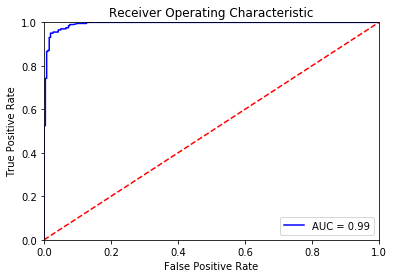

In [44]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#thanks to James Hampton for the link
model = gsLR
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('../images/roc.jpg');
plt.show()


We can also look at the predicted probabilities for each new post. Look at the predict probas. 

In [45]:
pred_df = pd.DataFrame({'cleaned_post': X_test,
                        'y_test': y_test,
                        'prediction': predictions,
                        'proba_not_travel': probs[:,0],
                        'proba_travel': probs[:,1]})
pred_df['misclassified'] = abs(pred_df['y_test'] - pred_df['prediction'])
                        

In [46]:
pred_df.head()

,cleaned_post,y_test,prediction,proba_not_travel,proba_travel,misclassified
227,so i m going to europe uk for a few weeks and ...,1,1,0.412025,0.587975,0
997,while at the gym i notice people lean with the...,0,0,0.942872,0.057128,0
790,im using my vacation to travel to morocco this...,1,1,0.228280,0.771720,0
224,my wife and i are traveling to spain this may ...,1,1,0.074150,0.925850,0
1801,my neighbor recently put out a perfectly new w...,0,0,0.972786,0.027214,0


In [47]:
missed_mask = pred_df['misclassified']==1

In [48]:
missed_df = pred_df[missed_mask]

In [49]:
missed_df

,cleaned_post,y_test,prediction,proba_not_travel,proba_travel,misclassified
1498,hey all first time poster in this sub new job ...,0,1,0.432670,0.567330,1
116,i m looking to take or days to head into b c f...,1,0,0.503158,0.496842,1
1620,i m heading to japan next week i ve heard rumo...,0,1,0.428324,0.571676,1
370,unaccompanied,1,0,0.673257,0.326743,1
132,as the title states i m looking for a hard she...,1,0,0.523562,0.476438,1
133,hi guys apologies if this has been asked befor...,1,0,0.559855,0.440145,1
178,so my family and i are traveling tomorrow my w...,1,0,0.628338,0.371662,1
468,my wife and i were hoping to visit israel and ...,1,0,0.633227,0.366773,1
177,i ve got a simple problem but couldn t find an...,1,0,0.633557,0.366443,1
1748,for the last several years my gf and i have be...,0,1,0.314038,0.685962,1


In [50]:
missed_df.loc[142]['cleaned_post']

'title says it all hey all i am applying for my first us passport and on the form it asks for mothers fathers name dob and birth place only my mom is listed on my birth certificate and when i asked her about dear ole dad she shrugged and said she didn t know or remember i m i ve never known my bio dad and have only known my step dad but he never adopted me what do i do for that question on the form the po is saying i got to put bio dads info there but what if i don t have it'

In [51]:
tfidf_vec = gsLR.best_estimator_.steps[0][1]

In [52]:
feature_names = gsLR.best_estimator_.steps[0][1].get_feature_names()

In [53]:
lr_mod = gsLR.best_estimator_.steps[1][1]

In [54]:
lr_coefs = lr_mod.coef_[0]

In [55]:
print(f'Check size of coefficients and features list match: coefs: {len(lr_coefs)}, features: {len(feature_names)}')

Check size of coefficients and features list match: coefs: 500, features: 500


#### Interpreting Coefficients
Create a dataframe to hold the coefficients for each feature, along with the odds of predicting a travel post given that feature appears in the post.

In [56]:
#Put the coeffs and the features in a dataframe
word_weight_df = pd.DataFrame({'word_features':feature_names,
                              'coefs':lr_coefs})
word_weight_df = word_weight_df.sort_values('coefs')
#Calculate the odds
word_weight_df['odds'] =  word_weight_df['coefs'].map(lambda x: np.exp(x) )
#Create a column to help explain the odds
#If the odds re between 0 and 1, the post is (1/odds -1) times less likely to be a travel post
#If the odss are greater than 1, the post is odds-1 times more likely to be a travel post
word_weight_df['odds explainer'] = word_weight_df['odds'].map(lambda x: (1/x)-1 if x < 1 else x-1 )

Look strongest predictors for r/travel are at highest positive values, at the tail of the dataframe. Let' look at the top 10.

In [57]:
word_weight_df.tail(10)

,word_features,coefs,odds,odds explainer
403,stay,1.737507,5.683160,4.683160
86,country,1.816125,6.147987,5.147987
316,planning,1.866739,6.467170,5.467170
124,europe,1.918747,6.812416,5.812416
462,visa,1.931882,6.902490,5.902490
312,places,2.133818,8.447057,7.447057
444,traveling,2.205422,9.074079,8.074079
149,flight,3.017605,20.442277,19.442277
448,trip,3.306685,27.294482,26.294482
443,travel,3.480759,32.484379,31.484379


The top ten predictors of a travel post certainly look like travel words. The number one predictor is the word 'travel' itself. If that appears in the post it is 31 times more likely to be in the travel thread. Likewise, if the word 'trip' appears in a post is it 26 times more likely to be in the travel post than if it did not appear. If the word 'flight' appears, it is 19 times more likely to be in travel, etc.. 

In [58]:
word_weight_df.head(10)

,word_features,coefs,odds,odds explainer
483,wine,-4.981654,0.006863,144.715262
45,bottle,-2.315388,0.098728,9.128855
179,gym,-2.044976,0.129383,6.728973
317,plant,-1.919387,0.146697,5.816780
484,wines,-1.814297,0.162952,5.136760
163,garden,-1.684489,0.185539,4.389699
490,workout,-1.519941,0.218725,3.571955
476,weight,-1.471567,0.229565,3.356057
418,tasting,-1.372867,0.253379,2.946650
384,soil,-1.272236,0.280204,2.568824


The top ten words that lead us to classify a post as not travel are the negative coefficients at the top of the dataframe. If the word wine appears in a post is it 114 times less likely to be in the travel post than if it did not appear. If the word gym appears, it is 6 times less likely to be in travel, etc.. 

In [59]:
#Extract the coefficients for each variable and sor by abs val visuallize the predictive value of each
##This code adapted from a sample provided by from James Hampton, and modified by Mark 
coef_df = pd.DataFrame([lr_coefs, feature_names], index = ['Coefficients', 'Features']).T
coef_df = coef_df.set_index('Features')
#coef_df['Coefficients'] = np.abs(coef_df['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=False)
coef_df.head(10)

,Coefficients
Features,
travel,3.48076
trip,3.30668
flight,3.01761
traveling,2.20542
places,2.13382
visa,1.93188
europe,1.91875
planning,1.86674
country,1.81612


Text(0.5, 0, 'Strenth of Predictor')

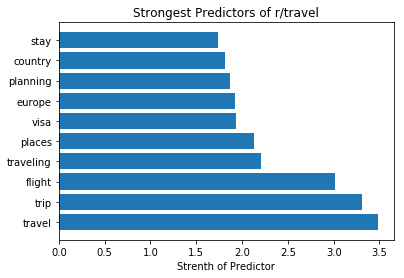

In [60]:
plt.barh(y=coef_df.index[:10], width=coef_df['Coefficients'][:10]);
plt.title('Strongest Predictors of r/travel')
plt.xlabel('Strenth of Predictor')

In [61]:
coef_df.shape

(500, 1)

In [62]:
start = coef_df.shape[0] - 10
start

490

Text(0.5, 0, 'Strenth of Predictor')

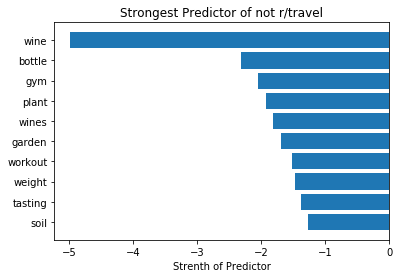

In [63]:
plt.barh(y=coef_df.index[start:], width=coef_df['Coefficients'][start:]);
plt.title('Strongest Predictor of not r/travel')
plt.xlabel('Strenth of Predictor')

<a id='section__Conclusion'></a>

### Conclusion

The model successfully classifies  r/travel, and not r/travel, with a 96% of the time!!!
This is not surprising, though. These topics have very distinguishing words. It may have been much harder with more similar threads.
It DOES do a good job of illustrating the classification techniques and the modeling process. 
Recommendation: DO HIRE DATA SCIENTISTS!!!!

[back to top](#section__top)
